# 🏡 Stable Diffusion Inpainting

1. 📹 Using tutorial from [1littlecoder](https://www.youtube.com/watch?v=N913hReVxMM) on youtube and accompanying [Colab Notebook](https://colab.research.google.com/drive/1R2HJvufacjy7GNrGCwgSE3LbQBk5qcS3?usp=sharing#scrollTo=BnobY4zi0Pjs).

2. 🤗 Using [Huggingface `diffusers` library](https://github.com/huggingface/diffusers).

In [1]:
import torch
print(f'Pytorch {torch.__version__}')
try:
    free, total = torch.cuda.mem_get_info()
    print(f'    GPU {torch.cuda.get_device_name(0)} ({total//1024**2} MB)')
except: print("No GPU detected")

Pytorch 1.12.1
    GPU NVIDIA GeForce RTX 2070 (8191 MB)


Install dependencies:

In [2]:
#! conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge
#! pip install https://github.com/huggingface/diffusers/archive/main.zip --ignore-installed
#! pip install transformers ftfy gradio  
#! pip install --ignore-installed Pillow==9.0.0
#! pip freeze | grep diffusers

In [3]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to C:\Users\Luke/.huggingface/token


In [2]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [4]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

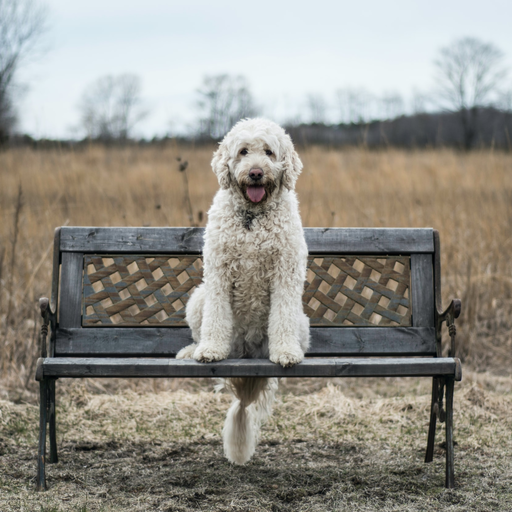

In [6]:
init_image

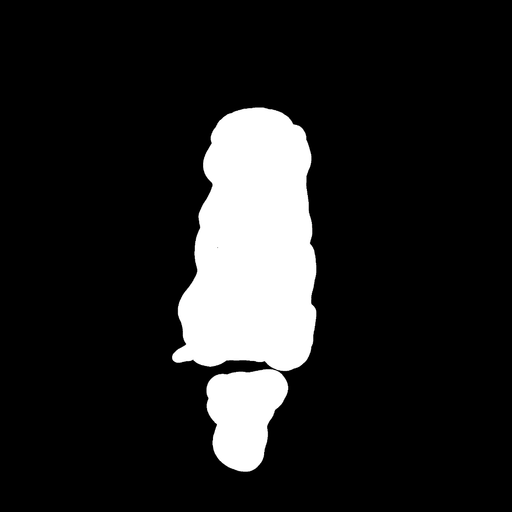

In [7]:
mask_image

In [8]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

0it [00:00, ?it/s]

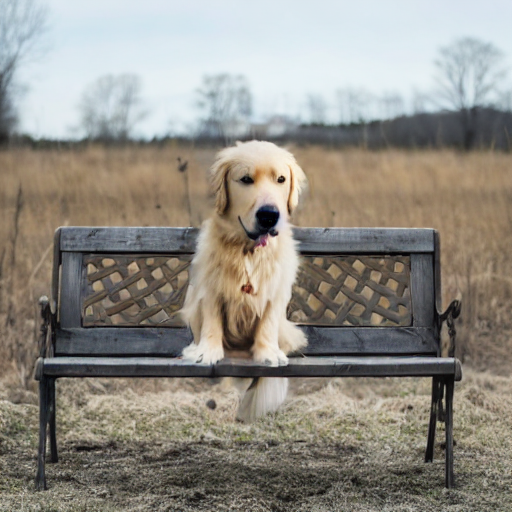

In [26]:
prompt = "photo of a Golden Retriever sitting on a bench, 500px"

with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, mask_image=mask_image, strength=0.8)["sample"]
    
images[0]

# Custom Masks using `Photopea`

In [95]:
init_image = PIL.Image.open('../inpainting/castle01.jpg').convert("RGB").resize((512, 512))
mask_image = PIL.Image.open('../inpainting/castle01_tower_masks.jpg').convert("RGB").resize((512, 512))

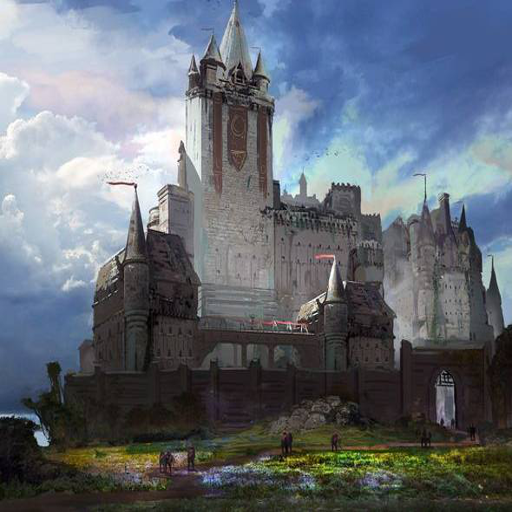

In [96]:
init_image

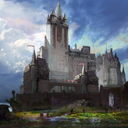

In [43]:
init_image.resize((128, 128))

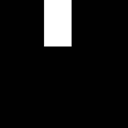

In [44]:
mask_image.resize((128, 128))

0it [00:00, ?it/s]

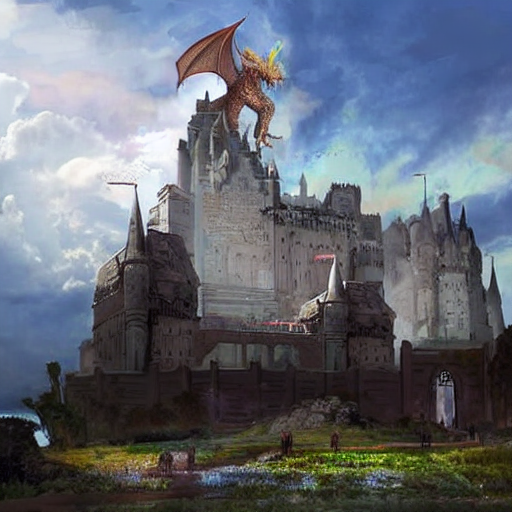

In [45]:
prompt = "A fantasy castle with a dragon defending. Trending on artstation, precise lineart, award winning, divine"

with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, mask_image=mask_image, strength=0.7)["sample"]
    
images[0]

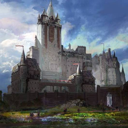

In [99]:
init_image = PIL.Image.open('../inpainting/castle20.jpg').convert("RGB").resize((512, 512))
mask_image = PIL.Image.open('../inpainting/castle20_mask.jpg').convert("RGB").resize((512, 512))
init_image.resize((128, 128))

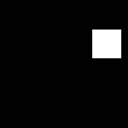

In [100]:
mask_image.resize((128, 128))

0it [00:00, ?it/s]

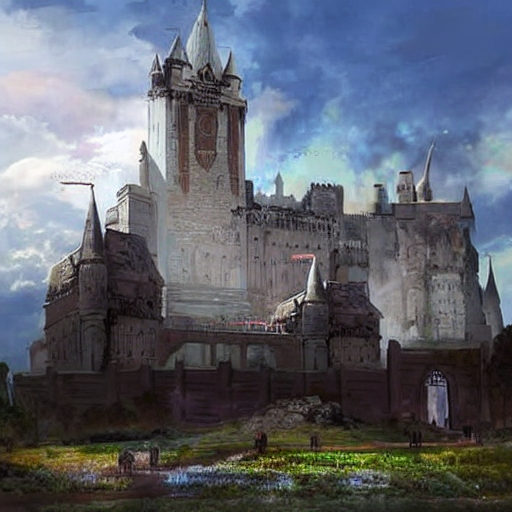

In [101]:
prompt = "A dragon sitting on top of a tower"

with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, mask_image=mask_image, strength=0.8)["sample"]
    
images[0]

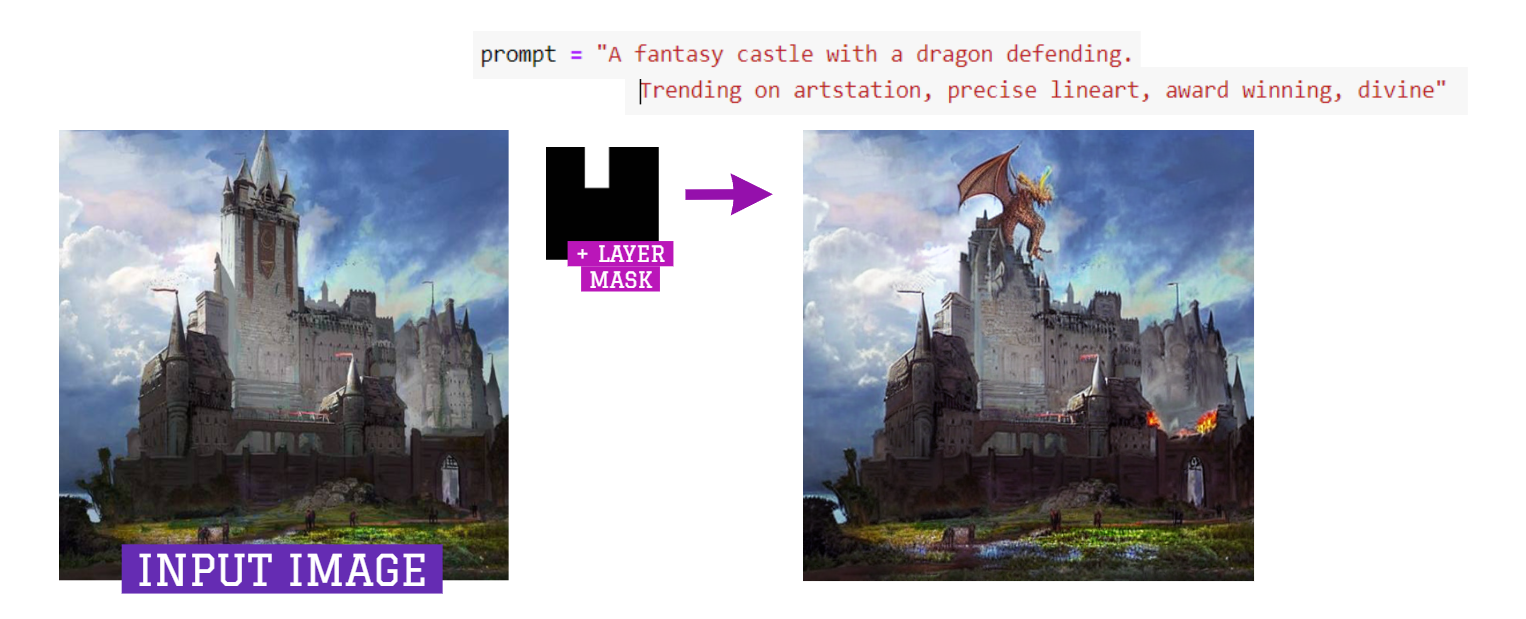

# 🕹️ `Gradio` UI

In [103]:
import gradio as gr

In [104]:
def predict(dict, prompt):
    init_img =  dict['image'].convert("RGB").resize((512, 512))
    mask_img = dict['mask'].convert("RGB").resize((512, 512))
    with autocast("cuda"):
        images = pipe(prompt=prompt, init_image=init_img, mask_image=mask_img, strength=0.75)["sample"]

    return(images[0])

In [105]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting Tool on Colab with Gradio',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x15d5ffdcee0>, 'http://127.0.0.1:7860/', None)

0it [00:00, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
